In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py
import re

from collections import defaultdict
from scipy.stats import ttest_ind

FPS = 60

## Load data

In [2]:
# Path to the .h5 file
file_path = '../syllable_analyses_julia_11_vids/results.h5'

# Initialize a dictionary to hold dfs for each Mouse ID
include_latent_state = False

# Using defaultdict in case there are multiple groups per Mouse ID
dfs = defaultdict(list)

# Regular expression pattern to extract Mouse ID
# Assumes Mouse ID is the number before 'DLC' in the group name
mouse_id_pattern = re.compile(r'_(\d+)DLC_')

with h5py.File(file_path, 'r') as file:
    for group_name in file.keys():
        # Extract Mouse ID using regex
        match = mouse_id_pattern.search(group_name)
        if match:
            mouse_id = match.group(1)
        else:
            # Handle cases where Mouse ID is not found
            print(f"Warning: Mouse ID not found in group name '{group_name}'. Skipping this group.")
            continue  # Skip this group
        
        # Check if Mouse ID already exists in the dictionary (this would indicate an error)
        if mouse_id in dfs:
            raise ValueError(f"Error: Multiple groups found for Mouse ID '{mouse_id}' in the file. Only one group per Mouse ID is expected.")
        
        group = file[group_name]
        
        # List to hold individual DataFrames for each dataset
        df_list = []
        
        for dataset_name in group.keys():
            # Exclude 'latent_state' datasets if the flag is False
            if not include_latent_state and dataset_name.startswith('latent_state'):
                continue
            
            dataset = group[dataset_name][:]
            
            # Check if dataset is at least 1D
            if dataset.ndim == 1:
                # Convert to 2D array with one column
                dataset = dataset.reshape(-1, 1)
            
            # Create column names by appending index to dataset name
            # Example: 'centroid_0', 'centroid_1', ...
            num_cols = dataset.shape[1]
            columns = [f"{dataset_name}_{i}" for i in range(num_cols)]
            
            # Convert dataset to DataFrame
            df = pd.DataFrame(dataset, columns=columns)
            df_list.append(df)
        
        if df_list:
            # Concatenate all DataFrames horizontally (axis=1)
            concatenated_df = pd.concat(df_list, axis=1)
            # Add to the dictionary with the Mouse ID as the key
            dfs[mouse_id] = concatenated_df
        else:
            print(f"Warning: No datasets found in group '{group_name}'.")

## Prepare data

In [3]:
for df in dfs.values():
    df['timestamp'] = df.index / FPS
    df['current_minute'] = df['timestamp'] / 60

In [4]:
syllable_info = pd.read_csv('../syllable_analyses_julia_11_vids/syllable,behavior_group_dim4.csv', index_col=0)
#pd.read_csv('../syllable_analysis_julia/syllable,behavior.csv', index_col=0)
#syllable_info.loc[41] = 'faulty'

syllable_map = syllable_info.to_dict()['behavior']

mouse_info = pd.read_csv('../syllable_analyses_julia_11_vids/syllables_mouseCoh1_info.csv', index_col=0)

In [5]:
for df in dfs.values():
    df['syllable_name'] = df['syllable_0'].map(syllable_map)
    df['syllable_name'] = df['syllable_name'].fillna('misc')  # Replace NaN with 'faulty'

## Split by injection

In [6]:
def bin_df_by_injection(df, mouse_id, bin_size=15, pre_duration=60, post_duration=90):
    # Get the relevant time intervals from the mouse_info DataFrame
    pre_inj_start, pre_inj_end, post_inj_start, post_inj_end = \
        mouse_info.loc[mouse_id][['PreInjStart', 'PreInjEnd', 'PostInjStart', 'PostInjEnd']].to_list()
    
    # Calculate the number of bins
    num_pre_bins = pre_duration // bin_size
    num_post_bins = post_duration // bin_size
    
    # Generate bin edges for pre-injection
    pre_bins = np.linspace(pre_inj_start, pre_inj_end, num_pre_bins + 1)
    # Generate bin edges for post-injection
    post_bins = np.linspace(post_inj_start, post_inj_end, num_post_bins + 1)
    
    # Create a dictionary to store the binned dataframes
    binned_dfs = {}
    
    # Bin the pre-injection data
    for i in range(num_pre_bins):
        start = pre_bins[i]
        end = pre_bins[i + 1]
        bin_df = df[(df['current_minute'] >= start) & (df['current_minute'] < end)]
        bin_label = f'pre_bin_{i + 1}'
        binned_dfs[bin_label] = bin_df
    
    # Bin the post-injection data
    for i in range(num_post_bins):
        start = post_bins[i]
        end = post_bins[i + 1]
        bin_df = df[(df['current_minute'] >= start) & (df['current_minute'] < end)]
        bin_label = f'post_bin_{i + 1}'
        binned_dfs[bin_label] = bin_df
    
    return binned_dfs

In [7]:
# Initialize a defaultdict to store binned dataframes
dfs_binned = defaultdict(list)

for mouse_id, df in dfs.items():
    genotype, _ = list(mouse_info.loc[int(mouse_id)])[:2]
    binned_dfs = bin_df_by_injection(df, int(mouse_id), bin_size=10)
    
    for bin_label, bin_df in binned_dfs.items():
        dfs_binned[(mouse_id, bin_label, genotype)] = bin_df

In [8]:
for k, v in dfs_binned.items():
    print(k, len(v))

('222', 'pre_bin_1', 'Het') 36000
('222', 'pre_bin_2', 'Het') 36000
('222', 'pre_bin_3', 'Het') 36000
('222', 'pre_bin_4', 'Het') 36000
('222', 'pre_bin_5', 'Het') 36000
('222', 'pre_bin_6', 'Het') 36000
('222', 'post_bin_1', 'Het') 36000
('222', 'post_bin_2', 'Het') 36000
('222', 'post_bin_3', 'Het') 36000
('222', 'post_bin_4', 'Het') 36000
('222', 'post_bin_5', 'Het') 36000
('222', 'post_bin_6', 'Het') 36000
('222', 'post_bin_7', 'Het') 36000
('222', 'post_bin_8', 'Het') 36000
('222', 'post_bin_9', 'Het') 36000
('214', 'pre_bin_1', 'WT') 36000
('214', 'pre_bin_2', 'WT') 36000
('214', 'pre_bin_3', 'WT') 36000
('214', 'pre_bin_4', 'WT') 36000
('214', 'pre_bin_5', 'WT') 36000
('214', 'pre_bin_6', 'WT') 36000
('214', 'post_bin_1', 'WT') 36000
('214', 'post_bin_2', 'WT') 36000
('214', 'post_bin_3', 'WT') 36000
('214', 'post_bin_4', 'WT') 36000
('214', 'post_bin_5', 'WT') 36000
('214', 'post_bin_6', 'WT') 36000
('214', 'post_bin_7', 'WT') 36000
('214', 'post_bin_8', 'WT') 36000
('214', 'po

## Calculate angular parameters

In [9]:
def compute_angular_velocity(df):
    # Unwrap the heading angles to prevent discontinuities
    df.loc[:, 'unwrapped_heading'] = np.unwrap(df['heading_0'])  # Use .loc[] to avoid the warning
    # Compute time differences
    df.loc[:, 'time_diff'] = df['timestamp'].diff().fillna(0)
    # Compute heading differences
    df.loc[:, 'heading_diff'] = df['unwrapped_heading'].diff().fillna(0)
    # Compute angular velocity
    df.loc[:, 'angular_velocity'] = df['heading_diff'] / df['time_diff']
    return df

In [10]:
# Apply the function to all DataFrames in dfs
for key, df in dfs.items():
    dfs[key] = compute_angular_velocity(df)  # Reassign the result to the original DataFrame

# Apply the function to all DataFrames in dfs_split
for key, df in dfs_binned.items():
    dfs_binned[key] = compute_angular_velocity(df)  # Reassign the result to the original DataFrame

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_19470/579445921.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'unwrapped_heading'] = np.unwrap(df['heading_0'])  # Use .loc[] to avoid the warning
/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_19470/579445921.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'time_diff'] = df['timestamp'].diff().fillna(0)
/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_19470/579445921.py:7: SettingWithCopyWarning: 

In [11]:
def remove_outliers_zscore_replace(df, threshold=3):
    # Calculate mean and standard deviation
    mean = df['angular_velocity'].mean()
    std = df['angular_velocity'].std()
    
    # Define upper and lower bounds based on the threshold
    upper_bound = mean + threshold * std
    lower_bound = mean - threshold * std
    
    # Replace outliers with the upper or lower bound using .loc[] to avoid warnings
    df.loc[:, 'angular_velocity_clean'] = df['angular_velocity'].clip(lower=lower_bound, upper=upper_bound)
    
    return df

In [12]:
# Apply the function to all DataFrames in dfs
for key, df in dfs.items():
    dfs[key] = remove_outliers_zscore_replace(df, threshold=3)

# Apply the function to all DataFrames in dfs_split
for key, df in dfs_binned.items():
    dfs_binned[key] = remove_outliers_zscore_replace(df, threshold=3)

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_19470/1311355301.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'angular_velocity_clean'] = df['angular_velocity'].clip(lower=lower_bound, upper=upper_bound)
/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_19470/1311355301.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'angular_velocity_clean'] = df['angular_velocity'].clip(lower=lower_bound, upper=upper_bound)
/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

grouped_rotations = defaultdict(list)

# Group the rotations by bin_label, genotype, and side
for k, df in dfs_binned.items():
    bin_label, genotype = k[1:]
    grouped_rotations[(bin_label, genotype)].append(-df['angular_velocity_clean'].sum() / 6.283)

# Convert grouped_rotations to a DataFrame
data = []
for k, v in grouped_rotations.items():
    bin_label, genotype = k
    average_rotation = sum(v) / len(v)  # Calculate the average rotation
    data.append({
        'bin_label': bin_label,
        'genotype': genotype,
        'side': side,
        'average_rotation': average_rotation
    })

df_plot = pd.DataFrame(data)

# Create a 'bin_number' column for sorting and plotting
def get_bin_number(bin_label):
    if 'pre_bin' in bin_label:
        return -int(bin_label.split('_')[-1])
    elif 'post_bin' in bin_label:
        return int(bin_label.split('_')[-1])
    else:
        return None

df_plot['bin_number'] = df_plot['bin_label'].apply(get_bin_number)

# Sort the DataFrame by 'bin_number'
df_plot = df_plot.sort_values('bin_number')

# Set up the seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(14, 7))

# Line plot with 'bin_number' on the x-axis and 'average_rotation' on the y-axis
sns.lineplot(
    data=df_plot,
    x='bin_number',
    y='average_rotation',
    hue='genotype',
    style='side',
    markers=True,
    dashes=False
)

# Customize the plot
plt.xlabel('Time Bins (Negative: Pre-injection, Positive: Post-injection)')
plt.ylabel('Average Rotations')
plt.title('Average Rotations Over Time Bins by Genotype and Side')
plt.legend(title='Genotype and Side', bbox_to_anchor=(1.05, 1), loc=10)
plt.xticks(df_plot['bin_number'].unique())

# Show the plot
plt.tight_layout()
plt.show()


NameError: name 'side' is not defined

## transition analysis

### transition matrices

In [14]:
def create_transition_matrix_exclude_faulty(dfs_binned, faulty_syllable, column='syllable_name'):
    all_syllables = set()

    # Step 1: Collect all unique syllables across all DataFrames, excluding the faulty syllable
    for df in dfs_binned.values():
        all_syllables.update(df[column].unique())
    
    # Remove the faulty syllable from the set
    all_syllables.discard(faulty_syllable)

    all_syllables = sorted(list(all_syllables))  # Convert to a sorted list for consistent ordering
    
    # Step 2: Use defaultdict to store transition matrices
    all_transition_matrices = defaultdict(list)
    
    for k, df in dfs_binned.items():
        # Remove rows that have the faulty syllable
        filtered_df = df[(df[column] != faulty_syllable)]

        # Remove consecutive duplicates
        filtered_df = filtered_df[filtered_df[column] != filtered_df[column].shift()]

        # Create an empty DataFrame for the transition matrix with all valid syllables
        transition_matrix = pd.DataFrame(0, index=all_syllables, columns=all_syllables)

        # Get transitions using shift
        transitions = pd.DataFrame({
            'current_syllable': filtered_df[column],
            'next_syllable': filtered_df[column].shift(-1)
        }).dropna()

        # Count transitions
        transition_counts = transitions.groupby(['current_syllable', 'next_syllable']).size()

        # Populate the transition matrix with raw counts
        for (current, next_), count in transition_counts.items():
            transition_matrix.loc[current, next_] += count

        # Store the raw transition matrix in the defaultdict
        all_transition_matrices[k] = transition_matrix

    return all_transition_matrices

In [15]:
# Assuming dfs_split is a dictionary of DataFrames and 'Faulty' is the faulty syllable
faulty_syllable = 'misc'

# Create transition matrices excluding the faulty syllable
all_transition_matrices = create_transition_matrix_exclude_faulty(dfs_binned, faulty_syllable)

In [16]:
all_transition_matrices.keys()

dict_keys([('222', 'pre_bin_1', 'Het'), ('222', 'pre_bin_2', 'Het'), ('222', 'pre_bin_3', 'Het'), ('222', 'pre_bin_4', 'Het'), ('222', 'pre_bin_5', 'Het'), ('222', 'pre_bin_6', 'Het'), ('222', 'post_bin_1', 'Het'), ('222', 'post_bin_2', 'Het'), ('222', 'post_bin_3', 'Het'), ('222', 'post_bin_4', 'Het'), ('222', 'post_bin_5', 'Het'), ('222', 'post_bin_6', 'Het'), ('222', 'post_bin_7', 'Het'), ('222', 'post_bin_8', 'Het'), ('222', 'post_bin_9', 'Het'), ('214', 'pre_bin_1', 'WT'), ('214', 'pre_bin_2', 'WT'), ('214', 'pre_bin_3', 'WT'), ('214', 'pre_bin_4', 'WT'), ('214', 'pre_bin_5', 'WT'), ('214', 'pre_bin_6', 'WT'), ('214', 'post_bin_1', 'WT'), ('214', 'post_bin_2', 'WT'), ('214', 'post_bin_3', 'WT'), ('214', 'post_bin_4', 'WT'), ('214', 'post_bin_5', 'WT'), ('214', 'post_bin_6', 'WT'), ('214', 'post_bin_7', 'WT'), ('214', 'post_bin_8', 'WT'), ('214', 'post_bin_9', 'WT'), ('237', 'pre_bin_1', 'Het'), ('237', 'pre_bin_2', 'Het'), ('237', 'pre_bin_3', 'Het'), ('237', 'pre_bin_4', 'Het'), 

In [17]:
# grouped_transitions = defaultdict(list)
grouped_transitions = {}

# Group the transition matrices by key (k[1:3])
for k, transition_matrix in all_transition_matrices.items():
    grouped_transitions[k] = [transition_matrix]
    #grouped_transitions[k[1:4]].append(transition_matrix)

# # Calculate the mean for each group, retaining indices
# for k, transition_matrices in grouped_transitions.items():
#     # Concatenate all matrices into a single DataFrame
#     concatenated = pd.concat(transition_matrices).astype(float).groupby(level=0).mean()
#     # Reassign the averaged transition matrix back to the dictionary
#     grouped_transitions[k] = concatenated

In [18]:
for k, g in grouped_transitions.items():
    print(k, len(g), g[0].shape)

('222', 'pre_bin_1', 'Het') 1 (10, 10)
('222', 'pre_bin_2', 'Het') 1 (10, 10)
('222', 'pre_bin_3', 'Het') 1 (10, 10)
('222', 'pre_bin_4', 'Het') 1 (10, 10)
('222', 'pre_bin_5', 'Het') 1 (10, 10)
('222', 'pre_bin_6', 'Het') 1 (10, 10)
('222', 'post_bin_1', 'Het') 1 (10, 10)
('222', 'post_bin_2', 'Het') 1 (10, 10)
('222', 'post_bin_3', 'Het') 1 (10, 10)
('222', 'post_bin_4', 'Het') 1 (10, 10)
('222', 'post_bin_5', 'Het') 1 (10, 10)
('222', 'post_bin_6', 'Het') 1 (10, 10)
('222', 'post_bin_7', 'Het') 1 (10, 10)
('222', 'post_bin_8', 'Het') 1 (10, 10)
('222', 'post_bin_9', 'Het') 1 (10, 10)
('214', 'pre_bin_1', 'WT') 1 (10, 10)
('214', 'pre_bin_2', 'WT') 1 (10, 10)
('214', 'pre_bin_3', 'WT') 1 (10, 10)
('214', 'pre_bin_4', 'WT') 1 (10, 10)
('214', 'pre_bin_5', 'WT') 1 (10, 10)
('214', 'pre_bin_6', 'WT') 1 (10, 10)
('214', 'post_bin_1', 'WT') 1 (10, 10)
('214', 'post_bin_2', 'WT') 1 (10, 10)
('214', 'post_bin_3', 'WT') 1 (10, 10)
('214', 'post_bin_4', 'WT') 1 (10, 10)
('214', 'post_bin_5', 

## PCA

In [19]:
grouped_transitions.keys()

dict_keys([('222', 'pre_bin_1', 'Het'), ('222', 'pre_bin_2', 'Het'), ('222', 'pre_bin_3', 'Het'), ('222', 'pre_bin_4', 'Het'), ('222', 'pre_bin_5', 'Het'), ('222', 'pre_bin_6', 'Het'), ('222', 'post_bin_1', 'Het'), ('222', 'post_bin_2', 'Het'), ('222', 'post_bin_3', 'Het'), ('222', 'post_bin_4', 'Het'), ('222', 'post_bin_5', 'Het'), ('222', 'post_bin_6', 'Het'), ('222', 'post_bin_7', 'Het'), ('222', 'post_bin_8', 'Het'), ('222', 'post_bin_9', 'Het'), ('214', 'pre_bin_1', 'WT'), ('214', 'pre_bin_2', 'WT'), ('214', 'pre_bin_3', 'WT'), ('214', 'pre_bin_4', 'WT'), ('214', 'pre_bin_5', 'WT'), ('214', 'pre_bin_6', 'WT'), ('214', 'post_bin_1', 'WT'), ('214', 'post_bin_2', 'WT'), ('214', 'post_bin_3', 'WT'), ('214', 'post_bin_4', 'WT'), ('214', 'post_bin_5', 'WT'), ('214', 'post_bin_6', 'WT'), ('214', 'post_bin_7', 'WT'), ('214', 'post_bin_8', 'WT'), ('214', 'post_bin_9', 'WT'), ('237', 'pre_bin_1', 'Het'), ('237', 'pre_bin_2', 'Het'), ('237', 'pre_bin_3', 'Het'), ('237', 'pre_bin_4', 'Het'), 

In [20]:
# Cell 1: Load Scaler and PCA Model, Apply to Current Data

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib

# ----------------------------
# Step 1: Load the Saved Scaler and PCA Model
# ----------------------------

# Replace 'path_to_scaler.pkl' and 'path_to_pca_model.pkl' with your actual file paths
scaler = joblib.load('scaler.pkl')  # Path to your saved scaler
pca = joblib.load('pca_model.pkl')  # Path to your saved PCA model

# ----------------------------
# Step 2: Prepare the Current Data
# ----------------------------

# Initialize lists to collect data and labels
data = []
bin_labels = []
genotype_side_labels = []

# Iterate over the grouped_transitions dictionary
for key, matrices in grouped_transitions.items():
    bin_label = key[1]  # Assuming key[1] is the bin label (e.g., 'pre_bin_1')
    genotype = key[2]
    side = 'dir'  # As per your current code, 'side' is set to 'dir'
    genotype_side_label = f'{genotype} {side}'  # Combine genotype and side
    
    for matrix in matrices:
        # Flatten each matrix and append to data
        data.append(matrix.values.flatten())
        # Append corresponding labels
        bin_labels.append(bin_label)
        genotype_side_labels.append(genotype_side_label)

# Convert the data list to a NumPy array
data = np.array(data)

# ----------------------------
# Step 3: Standardize the Data Using the Loaded Scaler
# ----------------------------

# Apply the scaler to the data
data_scaled = scaler.transform(data)

# ----------------------------
# Step 4: Project the Data Using the Loaded PCA Model
# ----------------------------

# Transform the scaled data using PCA
principal_components = pca.transform(data_scaled)  # Shape: (n_samples, n_components)

# ----------------------------
# Step 5: Prepare Variables for Plotting
# ----------------------------

# Convert bin labels to numerical bin numbers
def get_bin_number(bin_label):
    if 'pre_bin' in bin_label:
        return -int(bin_label.split('_')[-1])
    elif 'post_bin' in bin_label:
        return int(bin_label.split('_')[-1])
    else:
        return 0  # Assuming '0' for injection time if applicable

bin_numbers = [get_bin_number(label) for label in bin_labels]
bin_numbers = np.array(bin_numbers)

# Normalize bin numbers for the 'seismic' colormap
min_bin = bin_numbers.min()
max_bin = bin_numbers.max()
norm = plt.Normalize(vmin=min_bin, vmax=max_bin)
colormap = plt.get_cmap('seismic')

# Get unique genotype_side labels
unique_genotype_side_labels = np.unique(genotype_side_labels)

# Define marker types for each genotype_side combination
marker_types = ['o', 's', '^', 'D', 'v', '<', '>', 'p', 'h', '*', 'X', 'P', '+', 'x', '|', '_']
# Extend marker_types if needed
if len(unique_genotype_side_labels) > len(marker_types):
    print("Warning: Not enough marker types for all genotype-side combinations.")
marker_label_to_style = {label: marker_types[i % len(marker_types)] for i, label in enumerate(unique_genotype_side_labels)}

# Extract the first two principal components for 2D plotting
principal_components_2D = principal_components[:, :2]  # Shape: (n_samples, 2)

# ----------------------------
# Step 6: (Optional) Save the Transformed Principal Components
# ----------------------------

# Uncomment the following lines if you wish to save the principal components
# np.save('principal_components_new.npy', principal_components_2D)
# pc_columns = ['PC1', 'PC2']
# df_pcs = pd.DataFrame(principal_components_2D, columns=pc_columns)
# df_pcs['Label'] = labels  # Optional: Include labels for reference
# df_pcs.to_csv('principal_components_new.csv', index=False)


In [21]:
unique_genotype_side_labels

array(['Het dir', 'WT dir'], dtype='<U7')

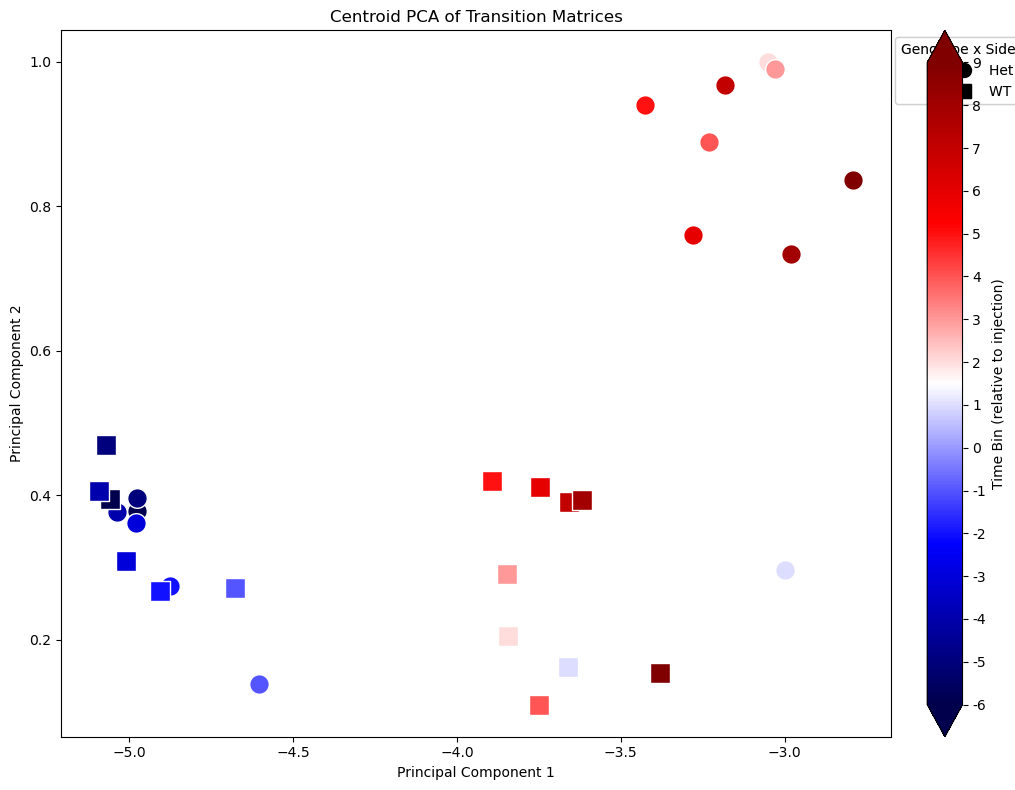

In [22]:
import pandas as pd
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

# Step 1: Create a DataFrame with the principal components and labels
df = pd.DataFrame({
    'PC1': principal_components_2D[:, 0],
    'PC2': principal_components_2D[:, 1],
    'Genotype_Side_Label': genotype_side_labels,
    'Bin_Number': bin_numbers
})

# Step 2: Group by both Genotype_Side_Label and Bin_Number
grouped = df.groupby(['Genotype_Side_Label', 'Bin_Number'])

# Step 3: Compute centroids for each group
df_centroids = grouped.mean().reset_index()

# Step 4: Prepare for plotting
unique_genotype_side_labels = df_centroids['Genotype_Side_Label'].unique()
min_bin = df_centroids['Bin_Number'].min()
max_bin = df_centroids['Bin_Number'].max()
norm = plt.Normalize(vmin=min_bin, vmax=max_bin)

# Step 5: Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Step 6: Plot centroids
for idx, row in df_centroids.iterrows():
    genotype_side_label = row['Genotype_Side_Label']
    bin_number = row['Bin_Number']
    pc1 = row['PC1']
    pc2 = row['PC2']
    
    # Get the marker for the genotype_side_label
    marker = marker_label_to_style[genotype_side_label]
    
    # Plot the centroid
    ax.scatter(
        pc1, pc2,
        c=[bin_number],  # Color based on bin_number
        cmap=colormap,
        norm=norm,
        marker=marker,
        s=200,
        edgecolor='w',
        linewidth=1.0
    )

# Step 7: Set labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Centroid PCA of Transition Matrices')

# Step 8: Create legend elements for genotype-side combinations (markers)
marker_legend_elements = [
    mlines.Line2D([], [], color='black', marker=marker_label_to_style[label],
                  linestyle='None', markersize=10, label=label)
    for label in unique_genotype_side_labels
]

# Add the marker legend
legend1 = ax.legend(handles=marker_legend_elements, title='Genotype x Side (Markers)',
                    loc='upper right', bbox_to_anchor=(1.25, 1))

# Step 9: Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Required for ScalarMappable

# Add the colorbar to the figure
cbar = fig.colorbar(sm, ax=ax, extend='both', fraction=0.046, pad=0.04)
cbar.set_label('Time Bin (relative to injection)')

# Optional: Set custom ticks for the colorbar
tick_bins = np.arange(min_bin, max_bin + 1)
cbar.set_ticks(tick_bins)
cbar.set_ticklabels([str(int(tick)) for tick in tick_bins])

# Step 10: Add the marker legend to the plot
ax.add_artist(legend1)

# Step 11: Adjust layout to accommodate legends and colorbar
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Step 12: Display the plot
plt.show()

### PCA features

In [23]:
np.sum(pca.explained_variance_ratio_)

0.7447606807957065

In [24]:
grouped_transitions[('222', 'pre_bin_1', 'Het')][0]

,groom/rear,orient left,orient right,pause&sniff,run,sit&sniff,turn left,turn right,walk,walk-pause
groom/rear,0,2,0,9,0,16,0,0,1,0
orient left,1,0,0,3,0,10,1,0,2,0
orient right,0,0,0,0,0,0,0,0,0,0
pause&sniff,6,4,0,0,0,26,9,2,2,0
run,0,0,0,1,0,0,0,0,1,0
sit&sniff,8,10,0,11,1,0,10,3,30,0
turn left,6,0,0,5,1,5,0,0,2,1
turn right,0,0,0,2,0,2,0,0,2,0
walk,7,1,0,18,0,15,0,0,0,0
walk-pause,0,0,0,0,0,0,0,0,1,0


In [25]:
# Compute the mean of the centroids
centroid_mean = df_centroids[['PC1', 'PC2']].mean().values  # This will be an array [mean_PC1, mean_PC2]

centroid_mean


array([-4.02126367,  0.46646811])

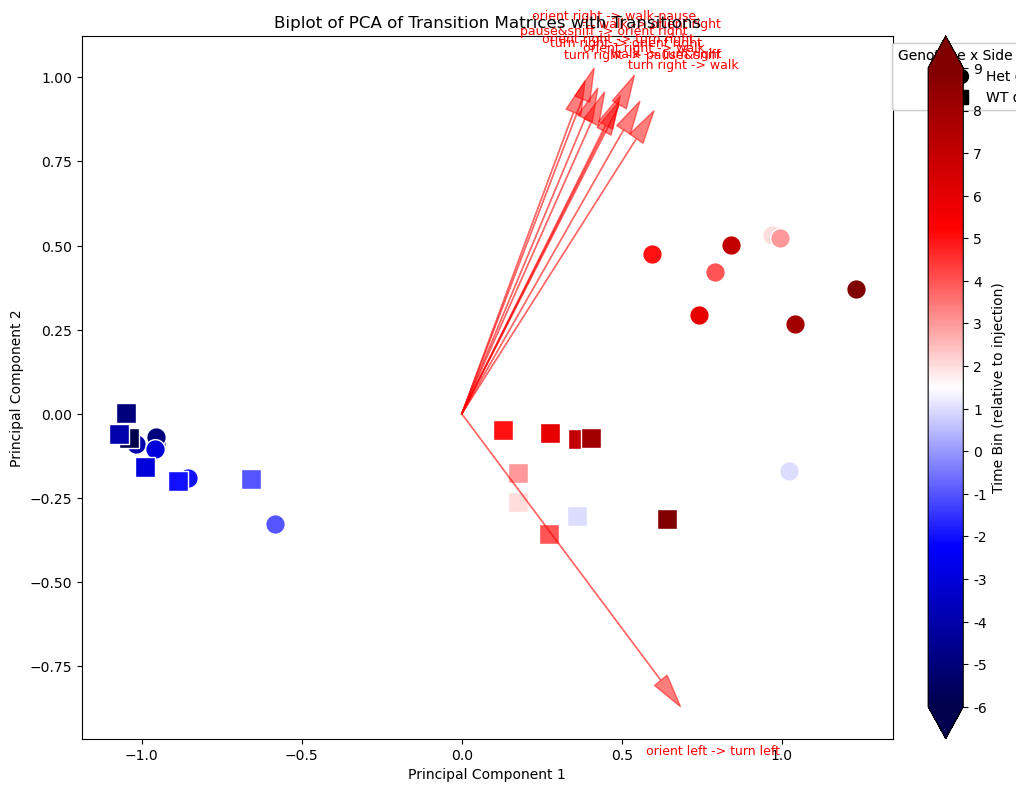

In [26]:
# New Cell: Create a Biplot with Transition Labels

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.cm import ScalarMappable
import matplotlib.lines as mlines

# ----------------------------
# Step 1: Get the List of Syllables
# ----------------------------

# Assuming all matrices have the same index and columns (syllables)
# We'll extract the syllable labels from one of the matrices

# Replace with an actual key from your data
sample_matrix = next(iter(grouped_transitions.values()))[0]
from_syllables = sample_matrix.index.tolist()
to_syllables = sample_matrix.columns.tolist()

# Number of syllables
n_syllables = len(from_syllables)

# ----------------------------
# Step 2: Map Feature Indices Back to Transitions
# ----------------------------

# Total number of features
n_features = n_syllables * n_syllables

# Create a list of all possible transitions
transitions = [f'{from_syllable} -> {to_syllable}' for from_syllable in from_syllables for to_syllable in to_syllables]

# ----------------------------
# Step 3: Compute the Loadings
# ----------------------------

# Loadings are the coefficients of the linear combination of the original variables
# For plotting, we'll use the first two principal components
loadings = pca.components_[:2, :]  # Shape: (2, n_features)

# Transpose to get shape (n_features, 2)
loadings = loadings.T

# ----------------------------
# Step 4: Compute the Magnitude of Each Loading Vector
# ----------------------------

# Calculate the magnitude (length) of each loading vector
loading_scores = np.sqrt(np.sum(loadings**2, axis=1))

# ----------------------------
# Step 5: Select Top Features Based on Their Contribution
# ----------------------------

# Number of features to display in the biplot
num_features_to_display = 10  # Adjust this number based on your data

# Get indices of the top features
top_features_indices = np.argsort(loading_scores)[-num_features_to_display:]

# Get the corresponding transitions and loadings
top_transitions = [transitions[idx] for idx in top_features_indices]
top_loadings = loadings[top_features_indices, :]

# ----------------------------
# Step 6: Plot the Biplot
# ----------------------------

fig, ax = plt.subplots(figsize=(12, 8))

# Plot the centroids as before
# (Using your existing code for plotting centroids)

# Plot Centroids (from your previous code)
for idx, row in df_centroids.iterrows():
    genotype_side_label = row['Genotype_Side_Label']
    bin_number = row['Bin_Number']
    pc1 = row['PC1']
    pc2 = row['PC2']
    
    # Get the marker for the genotype_side_label
    marker = marker_label_to_style[genotype_side_label]
    
    # Plot the centroid
    ax.scatter(
        pc1 - centroid_mean[0], pc2- centroid_mean[1],
        c=[bin_number],  # Color based on bin_number
        cmap=colormap,
        norm=norm,
        marker=marker,
        s=200,
        edgecolor='w',
        linewidth=1.0
    )

# ----------------------------
# Step 7: Overlay the Loadings as Arrows
# ----------------------------

# Scale the loadings for better visualization
scaling_factor = 5  # Adjust this value as needed

for i, transition in enumerate(top_transitions):
    ax.arrow(
        0, 0,  # Start at origin
        top_loadings[i, 0] * scaling_factor,
        top_loadings[i, 1] * scaling_factor,
        color='r',
        alpha=0.5,
        head_width=0.05,
        head_length=0.1,
        length_includes_head=True
    )
    ax.text(
        top_loadings[i, 0] * scaling_factor * 1.15,
        top_loadings[i, 1] * scaling_factor * 1.15,
        transition,
        color='r',
        ha='center',
        va='center',
        fontsize=9  # Adjust font size as needed
    )

# ----------------------------
# Step 8: Customize the Plot
# ----------------------------

# Set labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Biplot of PCA of Transition Matrices with Transitions')

# Create the marker legend (since we can't reuse the previous one)
unique_genotype_side_labels = df_centroids['Genotype_Side_Label'].unique()
marker_legend_elements = [
    mlines.Line2D([], [], color='black', marker=marker_label_to_style[label],
                  linestyle='None', markersize=10, label=label)
    for label in unique_genotype_side_labels
]

# Add the marker legend
legend1 = ax.legend(handles=marker_legend_elements, title='Genotype x Side (Markers)',
                    loc='upper right', bbox_to_anchor=(1.25, 1))

# Add the colorbar (recreating the ScalarMappable)
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Required for ScalarMappable

# Add the colorbar to the figure
cbar = fig.colorbar(sm, ax=ax, extend='both', fraction=0.046, pad=0.04)
cbar.set_label('Time Bin (relative to injection)')

# Optional: Set custom ticks for the colorbar
tick_bins = np.arange(min_bin, max_bin + 1)
cbar.set_ticks(tick_bins)
cbar.set_ticklabels([str(int(tick)) for tick in tick_bins])

# Add the marker legend to the plot
ax.add_artist(legend1)

# Adjust layout to accommodate legends and labels
plt.tight_layout(rect=[0, 0, 0.85, 1])

# ----------------------------
# Step 9: Display the Plot
# ----------------------------

plt.show()


In [27]:
points = []
labels = []

# Plot Centroids (from your previous code)
for idx, row in df_centroids.iterrows():
    genotype_side_label = row['Genotype_Side_Label']
    bin_number = row['Bin_Number']
    pc1 = row['PC1'] - centroid_mean[0]
    pc2 = row['PC2'] - centroid_mean[1]
    
    points.append((pc1, pc2))
    labels.append((bin_number, genotype_side_label))

In [28]:
points

[(-0.9562859114248177, -0.088088143417825),
 (-0.9551700830644387, -0.0703200689487477),
 (-1.0180425186840285, -0.08982226644553726),
 (-0.9580111877265578, -0.10468918881343425),
 (-0.8539223547820409, -0.19217736371646726),
 (-0.5839868901860177, -0.3282013289956632),
 (1.0223602005162737, -0.17049976096944486),
 (0.9703809978299747, 0.5322338276811756),
 (0.9934037012403292, 0.5230050550700407),
 (0.7901951357762473, 0.4216847834257243),
 (0.5949239971309148, 0.4737549461919622),
 (0.7409259888901873, 0.2941411440730159),
 (0.8401429238901357, 0.5013323295799661),
 (1.0415452691113525, 0.2668727485150559),
 (1.230794697758721, 0.3699395341564739),
 (-1.039290643446063, -0.07176993835328871),
 (-1.0492165092266443, 0.00362053815163077),
 (-1.0714391331504913, -0.06112684540848001),
 (-0.9881558096555354, -0.15693130334962385),
 (-0.8861882881713266, -0.1985573508566983),
 (-0.6578327331565941, -0.19490814543379786),
 (0.359053091694046, -0.3036302023376344),
 (0.17701154934439467, -

In [29]:
labels

[(-6, 'Het dir'),
 (-5, 'Het dir'),
 (-4, 'Het dir'),
 (-3, 'Het dir'),
 (-2, 'Het dir'),
 (-1, 'Het dir'),
 (1, 'Het dir'),
 (2, 'Het dir'),
 (3, 'Het dir'),
 (4, 'Het dir'),
 (5, 'Het dir'),
 (6, 'Het dir'),
 (7, 'Het dir'),
 (8, 'Het dir'),
 (9, 'Het dir'),
 (-6, 'WT dir'),
 (-5, 'WT dir'),
 (-4, 'WT dir'),
 (-3, 'WT dir'),
 (-2, 'WT dir'),
 (-1, 'WT dir'),
 (1, 'WT dir'),
 (2, 'WT dir'),
 (3, 'WT dir'),
 (4, 'WT dir'),
 (5, 'WT dir'),
 (6, 'WT dir'),
 (7, 'WT dir'),
 (8, 'WT dir'),
 (9, 'WT dir')]

In [30]:
df_centroids

,Genotype_Side_Label,Bin_Number,PC1,PC2
0,Het dir,-6,-4.977550,0.378380
1,Het dir,-5,-4.976434,0.396148
2,Het dir,-4,-5.039306,0.376646
3,Het dir,-3,-4.979275,0.361779
4,Het dir,-2,-4.875186,0.274291
5,Het dir,-1,-4.605251,0.138267
6,Het dir,1,-2.998903,0.295968
7,Het dir,2,-3.050883,0.998702
8,Het dir,3,-3.027860,0.989473
9,Het dir,4,-3.231069,0.888153


For k = 2, the Silhouette Score is 0.7065
For k = 3, the Silhouette Score is 0.7059
For k = 4, the Silhouette Score is 0.6520
For k = 5, the Silhouette Score is 0.5435
For k = 6, the Silhouette Score is 0.5016


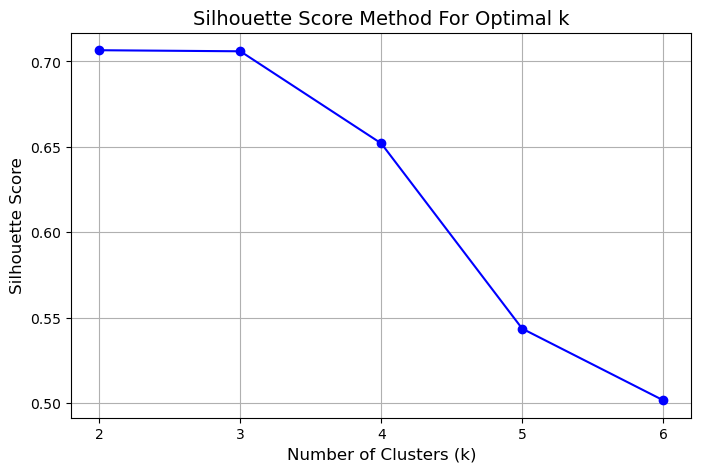

[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
('Het dir', 'Het dir', 'Het dir', 'Het dir', 'Het dir', 'Het dir', 'Het dir', 'Het dir', 'Het dir', 'Het dir', 'Het dir', 'Het dir', 'Het dir', 'Het dir', 'Het dir', 'WT dir', 'WT dir', 'WT dir', 'WT dir', 'WT dir', 'WT dir', 'WT dir', 'WT dir', 'WT dir', 'WT dir', 'WT dir', 'WT dir', 'WT dir', 'WT dir', 'WT dir')


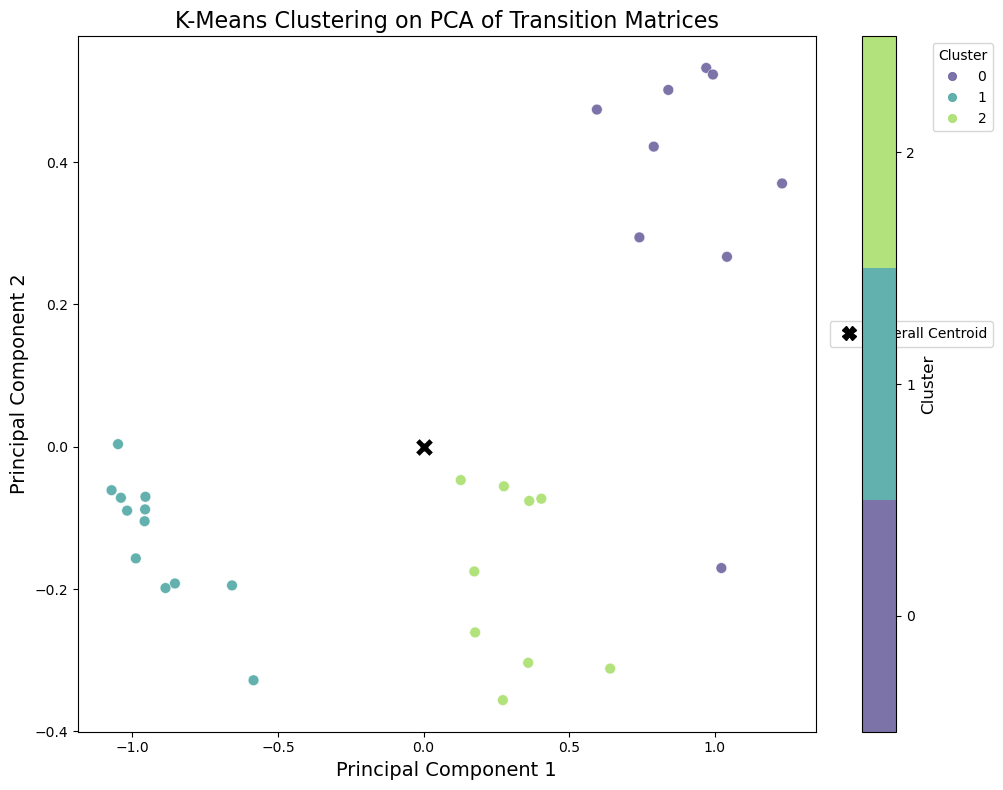

In [31]:
# New Cell: Perform K-Means Clustering and Analyze Transition Differences

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.cm import ScalarMappable
import matplotlib.lines as mlines

# ----------------------------
# Step 1: Prepare the Data for Clustering
# ----------------------------

# Define the data points: (PC1 - centroid_mean[0], PC2 - centroid_mean[1])
# Assuming 'df_centroids' and 'centroid_mean' are defined from the previous cell

points = []
labels = []

# Collect the centered coordinates of centroids
for idx, row in df_centroids.iterrows():
    bin_label = row['Bin_Number']
    genotype = row['Genotype_Side_Label']
    pc1 = row['PC1'] - centroid_mean[0]
    pc2 = row['PC2'] - centroid_mean[1]
    
    points.append((pc1, pc2))
    labels.append((bin_label, genotype))

data_for_clustering = np.asarray(points)  # Shape: (30, 2)

# ----------------------------
# Step 2: Determine the Optimal Number of Clusters (Optional)
# ----------------------------

# It's good practice to determine the optimal number of clusters using methods like the Elbow Method or Silhouette Score.
# Here, we'll demonstrate the Silhouette Score method for k ranging from 2 to 6.

silhouette_scores = []
K = range(2, 7)
for k in K:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    labels_temp = kmeans_temp.fit_predict(data_for_clustering)
    score = silhouette_score(data_for_clustering, labels_temp)
    silhouette_scores.append(score)
    print(f'For k = {k}, the Silhouette Score is {score:.4f}')

# Plot Silhouette Scores to choose the optimal k
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score Method For Optimal k', fontsize=14)
plt.xticks(K)
plt.grid(True)
plt.show()

# Based on the plot and scores, choose an optimal k. For demonstration, we'll choose k=3.
optimal_k = 3

# ----------------------------
# Step 3: Perform K-Means Clustering
# ----------------------------

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(data_for_clustering)
cluster_labels = kmeans.labels_

# Add cluster labels to the centroids DataFrame
df_centroids['Cluster'] = cluster_labels
print(cluster_labels)
print(list(zip(*labels))[1])

# ----------------------------
# Step 4: Visualize the Clusters on the PCA Biplot
# ----------------------------

# Create a new figure for the biplot with clusters
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each cluster with a distinct color
scatter = ax.scatter(
    data_for_clustering[:, 0],  # Centered PC1
    data_for_clustering[:, 1],  # Centered PC2
    c=df_centroids['Cluster'],
    cmap='viridis',
    norm=plt.Normalize(vmin=-0.5, vmax=optimal_k - 0.5),
    marker='o',
    s=60,
    edgecolor='w',
    linewidth=0.5,
    alpha=0.7,
    label='Clusters'
)

# Plot the overall centroid (should be at (0,0) after centering)
ax.scatter(
    0,  # Since data is centered
    0,
    c='black',
    marker='X',
    s=200,
    label='Overall Centroid',
    edgecolor='w',
    linewidth=1.5
)

# ----------------------------
# Step 5: Customize the Plot
# ----------------------------

# Set labels and title
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
ax.set_title('K-Means Clustering on PCA of Transition Matrices', fontsize=16)

# Create legend for clusters
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster", loc='upper right', bbox_to_anchor=(1.25, 1))
ax.add_artist(legend1)

# Add legend for the overall centroid
ax.legend(handles=[mlines.Line2D([], [], color='black', marker='X', linestyle='None',
                                markersize=10, label='Overall Centroid')], loc='upper right', bbox_to_anchor=(1.25, 0.6))

# Add colorbar representing clusters
cbar = plt.colorbar(scatter, ax=ax, boundaries=np.arange(-0.5, optimal_k + 0.5, 1), ticks=np.arange(0, optimal_k))
cbar.set_label('Cluster', fontsize=12)

# Adjust layout to accommodate legends
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Display the plot
plt.show()


In [32]:
df_transitions['Cluster']

NameError: name 'df_transitions' is not defined